In [72]:
import matplotlib.pyplot as plt
import datetime
import pandas as pd
import numpy as np
import seaborn as sns
from pandas.plotting import register_matplotlib_converters
import os
import matplotlib.dates as mdates

from statsmodels.tsa.seasonal import MSTL
from statsmodels.tsa.seasonal import DecomposeResult

In [45]:
plt.rc("figure", figsize=(16, 12))
plt.rc("font", size=13)

In [79]:
repopath = r'C:\Users\glima\OneDrive\Documentos\Mestrado_GitHub\DadosTermoeletricas\inputs'
df = pd.read_csv(os.path.join(repopath,'serie_historica_geracao_energia_ons_horaria_2020_a_2025.csv'))

In [47]:
df.head()

,hora,geracao_energia
0,1/1/2020 0:00,12
1,1/1/2020 15:00,11
2,2/1/2020 6:00,12
3,2/1/2020 21:00,12
4,3/1/2020 12:00,12


In [68]:
df.info()

<class 'pandas.DataFrame'>
RangeIndex: 2895 entries, 0 to 2894
Data columns (total 2 columns):
 #   Column           Non-Null Count  Dtype
---  ------           --------------  -----
 0   hora             2895 non-null   str  
 1   geracao_energia  2895 non-null   int64
dtypes: int64(1), str(1)
memory usage: 45.4 KB


In [80]:
df['hora'] = pd.to_datetime(df['hora'], format='%d/%m/%Y %H:%M', errors='coerce')
df['geracao_energia'] = df['geracao_energia'].astype(float)
df = df.set_index('hora')
df.info()

<class 'pandas.DataFrame'>
DatetimeIndex: 2895 entries, 2020-01-01 00:00:00 to NaT
Data columns (total 1 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   geracao_energia  2895 non-null   float64
dtypes: float64(1)
memory usage: 45.2 KB


<Axes: xlabel='hora'>

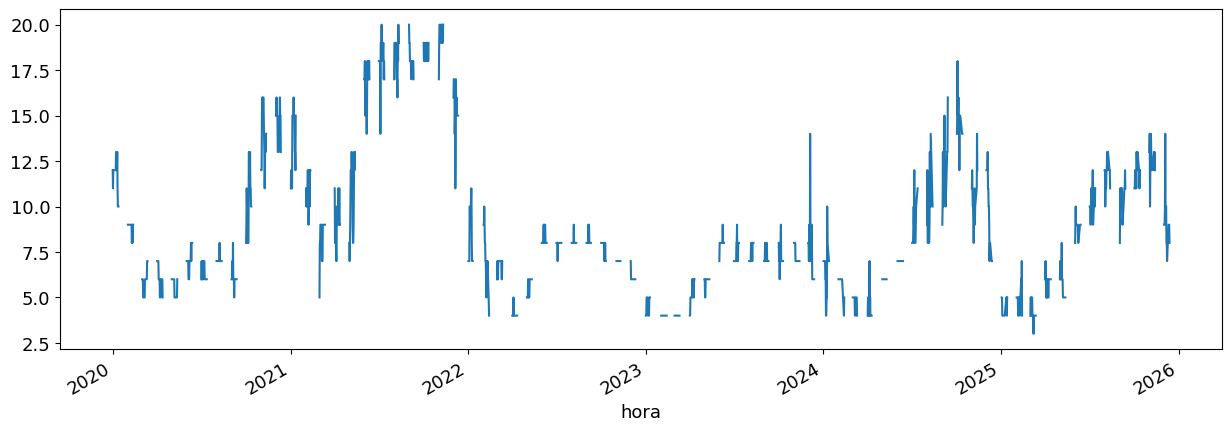

In [81]:
df["geracao_energia"].plot(figsize=[15, 5])

In [74]:
# 1. Garante que não há duplicatas no índice (essencial para o resample)
# Se houver duas leituras para a mesma hora, tiramos a média
df = df.groupby(level=0).mean()

# 2. Cria a sequência horária completa de 2020 até 2025
# Isso vai inserir as linhas que faltam com valor NaN
df_preenchido = df.resample('h').asfreq()

# 3. Interpola os valores vazios linearmente
df_preenchido['geracao_energia'] = df_preenchido['geracao_energia'].interpolate(method='linear')

# 4. Verifica se agora está tudo certo
print(f"Total de horas no novo DF: {len(df_preenchido)}")
print(df_preenchido.head())

Total de horas no novo DF: 52142
                     geracao_energia
hora                                
2020-01-01 00:00:00        12.000000
2020-01-01 01:00:00        11.933333
2020-01-01 02:00:00        11.866667
2020-01-01 03:00:00        11.800000
2020-01-01 04:00:00        11.733333


<Axes: xlabel='hora'>

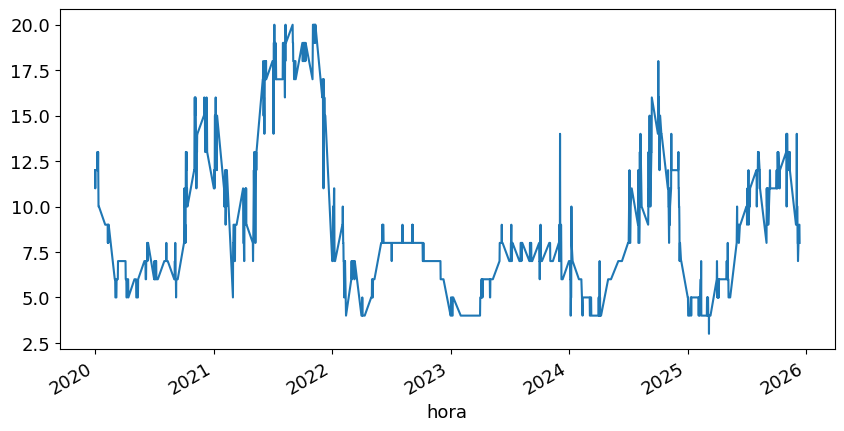

In [75]:
df["geracao_energia"].plot(figsize=[10, 5])

In [82]:
mstl = MSTL(df["geracao_energia"], periods=[24, 24 * 30])
res = mstl.fit()

In [87]:
res.seasonal.head()

,seasonal_24,seasonal_720
hora,,
2020-01-01 00:00:00,0.262077,6.201884
2020-01-01 15:00:00,-0.474711,5.537188
2020-01-02 06:00:00,0.666596,5.611053
2020-01-02 21:00:00,0.475966,5.921681
2020-01-03 12:00:00,1.041511,5.473610


ValueError: Axis limits cannot be NaN or Inf

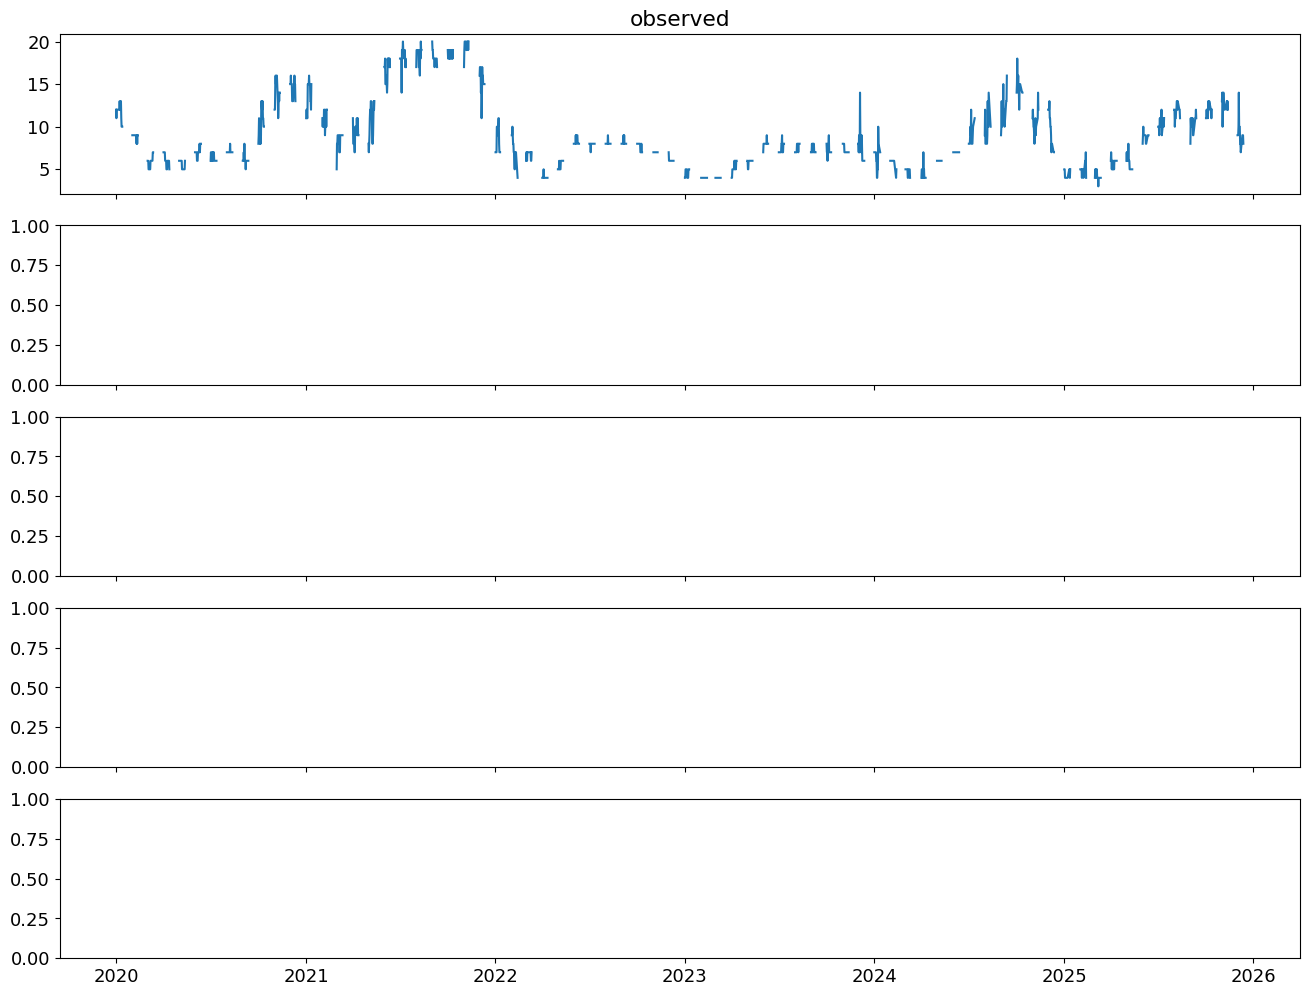

In [88]:
fig = res.plot()

for ax in fig.get_axes():
    # 1. Define o grid para cada mês
    ax.xaxis.set_major_locator(mdates.MonthLocator(interval=3)) # Rótulo a cada 3 meses
    ax.xaxis.set_minor_locator(mdates.MonthLocator())           # Linha de grid em cada mês
    
    # 2. Formata a data (Jan/20)
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%b/%y'))
    
    # 3. Ativa grids (Major e Minor)
    ax.grid(True, which='major', linestyle='-', alpha=0.5)
    ax.grid(True, which='minor', linestyle='--', alpha=0.3)
    
    # Rotaciona os meses para melhor leitura
    plt.setp(ax.get_xticklabels(), rotation=45, ha='right')

#plt.tight_layout()
plt.show()